# Shrinkage methods: Ridge and LASSO

## Ridge Regression

Ridge regression shrinks coefficients, $\hat{\beta}$, by penalizing the residual sum of squares with a Lagrange multiplier, $\lambda$. 


$$
\hat{\beta}^{ridge} = \operatorname*{arg\,min}_\beta \bigg\{ \sum_{i=1}^{N}\big(y_i - \beta_0 - \sum_{j=1}^{p} x_{ij}\beta_j\big)^2 +\lambda \sum_{j=1}^{p} \beta^2_j\bigg\}
$$

Written as the optimization,


$$
\hat{\beta}^{ridge} = \operatorname*{arg\,min}_\beta \sum_{i=1}^{N}\big(y_i - \beta_0 - \sum_{j=1}^{p} x_{ij}\beta_j\big)^2,\\
\sum_{j=1}^{p} \beta^2_j\leq t
$$

for some $t>0$.
In matrix notation, the lagrangian is written as, 

$$
L(X,t,\lambda^*,\beta ) =\|Y - X\beta\|_2^2 + \lambda^*(\|\beta\|_2^2 - t)
$$

where $\|\bullet\|$ denotes the $L_2$ norm. The optimal solution for the estimator, $\hat{\beta}^{ridge}$, is proved with Karush-Kuhn-Tucker (KKT) conditions,
$\nabla_{\beta} L(X,c,\lambda^*,\beta ) = 0$ (stationarity) and $\lambda^*(\|\beta(\lambda^*)\|_2^2 - t) = 0$ (Complementary slackness
). With the KKT conditions, 

$$
-2X^T(Y-X\beta) + 2t\beta = 0,\\
\lambda^*(\|\beta(\lambda^*)\|_2^2 - t) = 0
$$

Both conditions are satisfied if $\lambda^* = \lambda$ and $t = \lambda^*\|\beta(\lambda^*)\|_2^2$. 

The solution to the ridge estimator is solved similar to linear regression.

$$
RSS = (Y-\beta X)^T(Y-\beta X) - \lambda \beta^T \beta
$$

where the solution is 

$$
\hat{\beta}^{ridge} = (X^TX - \lambda I)^{-1} X^T Y
$$

## LASSO Regression


Lasso regression is similar to ridge regression however $L_2$ penalty is replaced by the $L_1$ penalty.

$$
\hat{\beta}^{ridge} = \operatorname*{arg\,min}_\beta \sum_{i=1}^{N}\big(y_i - \beta_0 - \sum_{j=1}^{p} x_{ij}\beta_j\big)^2,\\
\sum_{j=1}^{p} \mid\beta_j\mid \leq t
$$


Coordinated Decent is an efficient method for solving ridge and lasso problems.

### Coordinated Descent (Algorithim):


Coordinate descent is done by iteratively regressing a predictor ($X_j$) on all currently explained predictors $X_{-j}$. $X\beta$ can be split into $Y = X_j\beta_j + X_{-j}\beta_{-j}$. 

$$
Y = X_j\beta_j + X_{-j}\beta_{-j}\\
X_j \beta_j = y - x_{-j}\beta_{-j}\\
X_j^T X_j \beta_j = X_j^T (y - x_{-j}\beta_{-j})\\
\beta_j = \frac{X_j^T}{X_j^T X_j }(y - x_{-j}\beta_{-j})
$$

One cycle of coordinate descent iterates over each predictor. For a given set of parameters this is repeated. Typically, the algorithim is run for a value of $\lambda$ such that $\beta(\lambda_{max}) = 0$. This is repeated for a smaller value of $\lambda$ using the previous of $\lambda$ as a 'warm-start'. 

In [64]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})

#for comparision
from sklearn import linear_model
from sklearn import datasets


import warnings
warnings.filterwarnings("ignore")


#testing with the prostate dataset
df = pd.read_csv('./prostate.data',sep='\s+')
df.head()


#split train and test
df_train = df.loc[df['train'] == 'T']
df_test = df.loc[df['train'] == 'F']
#drop train column
df_train = df_train.drop(['train'],axis=1)
df_test = df_test.drop(['train'],axis=1)
x_train = df_train[['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']].to_numpy()
y_train = df_train[['lpsa']].to_numpy()
x_test = df_test[['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']].to_numpy()
y_test = df_test[['lpsa']].to_numpy()
predictors = ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']
p = len(predictors)
cs = sns.color_palette("Set2", p)

#for ridge regression standardize the predictors
x_train = (x_train - np.mean(x_train,axis=0))/np.std(x_train,axis=0)
x_test = (x_test - np.mean(x_test,axis=0))/np.std(x_test,axis=0)

y_train = (y_train - np.mean(y_train,axis=0))/np.std(y_train,axis=0)
y_train = (y_train - np.mean(y_train,axis=0))/np.std(y_train,axis=0)

In [65]:
#Method Use Coordinate descent to solve for betas 
import copy
beta = np.zeros((x_train.shape[1],1))

#Lasso coefficient/L1
def soft_threshold_l1(t : float,_lambda : float) -> float:
    m = abs(t)
    if t > 0 and m > _lambda:
        return m - _lambda
    elif t < 0 and m > _lambda:
        return _lambda - m
    else:
        return 0.0

#Ridge coefficient/L2 
def soft_threshold_l2(t : float ,_lambda : float) -> float:
    return t / (1.0+_lambda)
    
#Coordinate descent
def coordinate_descent(lambda_range,x_train, y_train, beta, iterations=100, model = 'lasso'):
    #Iterative Over Lambdas 
    #Start with beta(lambda_max) = 0
    #then decrease to warm start the solution
    for k,lval in enumerate(lambda_range):
        #initalize r values 
        r = y_train - x_train @ beta
        for i in range(iterations):
            
            #iterate over predictors
            for j in range(beta.shape[0]):
                temp_beta = copy.deepcopy(beta)
                temp_beta[j] = 0.0
                r = y_train - x_train @ temp_beta
                xtx = np.sum(x_train[:,j]**2)
                betaj = (1/xtx) * (x_train[:,j].T @ r)
                if model == 'lasso':
                    beta[j] = soft_threshold_l1(betaj[0],lval)
                elif model == 'ridge':
                    beta[j] = soft_threshold_l2(betaj[0],lval)

        lambda_sol[k] = beta.T
    return lambda_sol


(0.035399060013482114,
 70.55272086458793,
 -0.28090154214315,
 0.6347657236127785)

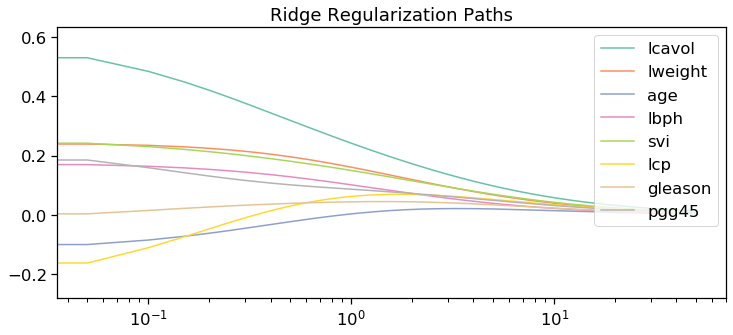

In [66]:
#Ridge Solutions  
lambda_tot = 1000
lambda_sol = np.zeros((lambda_tot,beta.shape[0]))
lambda_range = np.arange(0,50,50.0/lambda_tot)[::-1]
lambda_sol = coordinate_descent(lambda_range, x_train, y_train, beta, model = 'ridge')

m,n = x_train.shape

#Solution via coordinate_descent method
fig, ax = plt.subplots(1,1,figsize=(12,5))
x = lambda_range
ax.set_title("L2/Ridge Regularization Path")
for i in range(n):
    ax.semilogx(x, lambda_sol[:,i],color=cs[i],label=predictors[i])
    

ax.set_title('Ridge Regularization Paths')
ax.legend(loc='upper right')
plt.axis('tight')

(2.2341606180573485e-05,
 1.2029494762168695,
 -0.28064122726898855,
 0.6346202023890164)

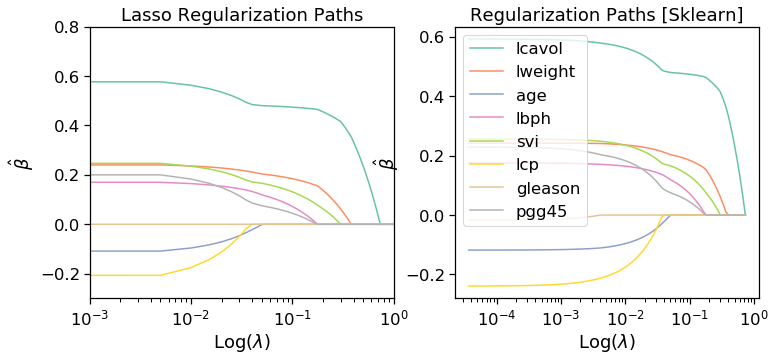

In [67]:
#Lasso Solutions  
lambda_tot = 200
lambda_sol = np.zeros((lambda_tot,beta.shape[0]))
lambda_range = np.arange(0,1,1.0/lambda_tot)[::-1]
lambda_sol = coordinate_descent(lambda_range, x_train, y_train, beta, model = 'lasso')

m,n = x_train.shape

#Solution via coordinate_descent method
fig, ax = plt.subplots(1,2,figsize=(12,5))
x = lambda_range
ax[0].set_title("L1/LASSO Regularization Path")
for i in range(n):
    ax[0].semilogx(x, lambda_sol[:,i],color=cs[i],label=predictors[i])
    
    
#sklearn validation 
alphas_lasso, coefs_lasso, _ = linear_model.lasso_path(x_train, y_train,\
                                                       5e-5 , fit_intercept=False)
for i in range(n):
    ax[1].semilogx(alphas_lasso, coefs_lasso[0][i],\
                   label = predictors[i], color=cs[i])

for a in ax:
    a.set_xlim((0.001,1))
    a.set_ylim((-0.3,0.8))
    a.set_xlabel(r"Log($\lambda$)")
    a.set_ylabel(r"$\hat{\beta}$")    


ax[0].set_title('Lasso Regularization Paths')
ax[1].set_title('Regularization Paths [Sklearn]')
ax[1].legend()
plt.axis('tight')